In [1]:
# set imports
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy import stats
from datetime import date
from ds_functions import * 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV

random_state = 1

In [2]:
# read in data

train_file = './train_users_2.csv.zip'

df = zip_to_df(train_file)


In [3]:
# Data clean up. 

df['gender'].replace('-unknown-', 'UNKNOWN', inplace=True)
df['gender'].replace(np.NaN, 'UNKNOWN', inplace=True)

# convert timestamp_first_active from string to datetime
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')

# set datetime values to datetime types
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])


# the 'age' column has some extreme outliers and lots of missing values
# create a function for correcting values in age column, then apply
def check_age(age):
    if age in (np.nan, np.NaN):
        return np.NaN
    elif age >= 1000:
        # if age > 1000, I assume that the age value is actually birth year
        # subtract birth year from current year to calculate age
        return date.today().year - age
    else:
        return age
    
df['age'] = df['age'].apply(check_age)

# also add an age_group column

def age_group(age):
    if age in range(19):
        return '0-18'
    elif age in range(19, 26):
        return '19-25'
    elif age in range(26,36):
        return '26-35'
    elif age in range(36,51):
        return '36-50'
    elif age in range(51, 66):
        return '51-65'
    elif age > 65:
        return '66+'
    
df['age_group'] = df.age.apply(age_group)
df['age_group'].fillna('Unknown', inplace=True)
    
# calculate number of days to book 
df['days_to_book'] = df[df.country_destination != 'NDF'].date_first_booking - df[df.country_destination != 'NDF'].date_account_created
df['days_to_book'] = df.days_to_book.dt.days

# add a device class columns (desktop, phone, tablet, or unknown)

def get_device_class(val):
    if str(val).lower().find('desktop') > 0:
        return 'Desktop'
    elif str(val).lower().find('phone') > 0:
        return 'Phone'
    elif val in ('iPad', 'Android Tablet'):
        return 'Tablet'
    else:
        return 'Unknown'

df['first_device_class'] = df['first_device_type'].apply(get_device_class)

# also add a 'affiliate provider' type column

def get_aff_provider_type(val):
    search_engines = ('google', 'bing', 'baidu', 'yahoo', 
                     'yandex', 'naver', 'daum')
    direct = ('direct', 'email-marketing')
    social = ('facebook', 'meetup', 'facebook-open-graph', 'wayn')
    
    if str(val).lower() in direct:
        return 'direct'
    elif str(val).lower() in search_engines:
        return 'search'
    elif str(val).lower() in social:
        return 'social'
    else:
        return 'other'
    
df['affiliate_provider_type'] = df.affiliate_provider.apply(get_aff_provider_type)


In [4]:
# I want to convert this into a 3 category classification problem 
# NDF (No Destination Found), US, and other are the 3 most popular 
# destinations by a wide margin. Using a 12 category classification
# categories other than NDF, US, and other have very low accuracy. 

# by reconfiguring into a 3 category classification problem, can
# model accuracy be improved?

def country_group(cn):
    if cn in ('NDF','US'):
        return cn
    else:
        return 'other'
    
df['country_group'] = df.country_destination.apply(country_group)
print(df.country_group.value_counts())

NDF      124543
US        62376
other     26532
Name: country_group, dtype: int64


In [6]:
# Separate into target and features datasets, one hot encode, and create test/train groups
X_train, X_test, y_train, y_test = create_test_train(df)
sorted_classes = y_test.unique()


score: 0.8803522908273212
classification report (MLP):
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.71      1.00      0.83      6256
      other       0.35      0.01      0.01      2543

avg / total       0.84      0.88      0.83     21346



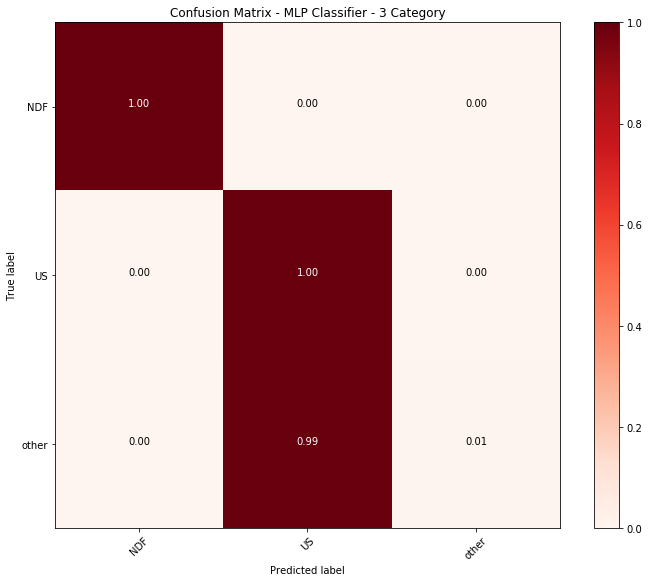

In [7]:
# Setup MLP
mlp = MLPClassifier()

# fit the training data
mlp.fit(X_train, y_train)
# scoring
y_pred = mlp.predict(X_test)
print('score:', mlp.score(X_test, y_test))
print('classification report (MLP):\n', 
      classification_report(y_test, y_pred))

_ = cm_plot(confusion_matrix(y_test, y_pred), classes=sorted_classes, 
            title='Confusion Matrix - MLP Classifier - 3 Category', normalize=True)
plt.show()


In [ ]:
# let's try many models
#Defining the classifiers
classifiers = {
        'svm' : SVC(probability=True), 
        'rf'  : RandomForestClassifier(n_estimators=100, n_jobs=2), 
        'gb' : GradientBoostingClassifier(n_estimators=50), 
        'etc' : ExtraTreesClassifier(n_estimators=100, n_jobs=2),
        'mlp'  : MLPClassifier()
}
    
#predictions on the validation and test sets
p_test = []
p_score = {}
p_classrpt = {}
   
for nm, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    p_test.append(y_prob)
    p_score[nm] = clf.score(X_test, y_test)
    p_classrpt[nm] = classification_report(y_test, y_pred)


In [14]:
for k, v in p_classrpt.items():
    print('{0}:\n{1}'.format(k, v))

svm:
             precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.71      1.00      0.83      6256
      other       0.44      0.00      0.00      2543

avg / total       0.85      0.88      0.83     21346

rf:
             precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.72      0.83      0.77      6256
      other       0.33      0.20      0.25      2543

avg / total       0.84      0.86      0.84     21346

gb:
             precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.71      1.00      0.83      6256
      other       0.00      0.00      0.00      2543

avg / total       0.80      0.88      0.83     21346

etc:
             precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.72      0.81      0.76      6256
      other       

In [15]:
for k, v in p_score.items():
    print('{0}:\n{1}'.format(k, v))

svm:
0.8808207626721634
rf:
0.8551953527592991
gb:
0.8808207626721634
etc:
0.8509322589712358
mlp:
0.8807739154876791


In [26]:
# SVC appears to give the best results with higest precision
# Do a random search for parameter optimization.
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

param_svc = {
    'C': np.logspace(-3, 2, 6),
    'kernel': ['linear', 'rbf'],
    'degree': np.arange( 0, 100+0, 1 ),
    'gamma': np.logspace(-3, 2, 6),
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': np.arange( 0.001, 0.01+0.001, 0.001 ),
    'cache_size': [2000],
    'class_weight': [None],
    'max_iter': [-1],
    'random_state': random_state,
    }

svc_cv = RandomizedSearchCV(SVC(), param_svc, n_iter=10, n_jobs=3)

In [ ]:
svc_cv.fit(X_train, y_train)


In [9]:
# Instead of a three category classificaton problem, can we reformat as a set of multiple two-category classifications
df2 = df.copy()
df2['booked'] = df2.country_destination.apply(lambda x: 0 if x == 'NDF' else 1)

y2 = df2.booked

# predictors are every variable except  country_desintation and the date values. 
# (days between date_account_created and date_first_booking is stored as calculated column)
X2 = df2.drop(['id', 'country_group', 'country_destination', 'date_account_created', 'timestamp_first_active', 
            'date_first_booking', 'booked'], axis=1)

# one hot encode
X2_onehot = pd.get_dummies(X2) 
X2_onehot.age = X2_onehot.age.fillna(0)
X2_onehot.days_to_book = X2_onehot.days_to_book.fillna(100000)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_onehot, y2, test_size=0.1, random_state=1)

# set up MLP
mlp_booked = MLPClassifier()

# fit the training data
mlp_booked.fit(X2_train, y2_train)
# scoring
y_pred_booked = mlp_booked.predict(X2_test)
print('score:', mlp_booked.score(X2_test, y2_test))
print('classification report (MLP):\n', 
      classification_report(y2_test, y_pred_booked))

# accuracy of 100% . That's not surprising since users who didn't book will all have 
# values of 100,000 for column 'days to book' 


score: 1.0
classification report (MLP):
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     12547
          1       1.00      1.00      1.00      8799

avg / total       1.00      1.00      1.00     21346



In [10]:
# Try the same as above, except use 'US' or 'non-US' as target variable
df3 = df.copy()
df3['booked_us'] = df3.country_destination.apply(lambda x: 1 if x == 'US' else 0)

y3 = df3.booked_us

# predictors are every variable except  country_desintation and the date values. 
# (days between date_account_created and date_first_booking is stored as calculated column)
X3 = df3.drop(['id', 'country_group', 'country_destination', 'date_account_created', 'timestamp_first_active', 
            'date_first_booking', 'booked_us'], axis=1)

# one hot encode
X3_onehot = pd.get_dummies(X3) 
X3_onehot.age = X3_onehot.age.fillna(0)
X3_onehot.days_to_book = X3_onehot.days_to_book.fillna(100000)

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3_onehot, y3, test_size=0.1, random_state=1)

# set up MLP
mlp_booked_us = MLPClassifier()

# fit the training data
mlp_booked_us.fit(X3_train, y3_train)
# scoring
y_pred_booked_us = mlp_booked_us.predict(X3_test)
print('score:', mlp_booked_us.score(X3_test, y3_test))
print('classification report (MLP):\n', 
      classification_report(y3_test, y_pred_booked_us))

# The accuracy is about the same as when using a 12-category classification. 
# US trips are not distinct enough from others for the model to be able to accurately identify them


score: 0.8775883069427527
classification report (MLP):
              precision    recall  f1-score   support

          0       0.99      0.83      0.91     15090
          1       0.71      0.98      0.82      6256

avg / total       0.91      0.88      0.88     21346



In [11]:
# lastly let's try with other (i.e. non US) vs. non-other (US or NDF)
df4 = df.copy()
df4['booked_other'] = df4.country_group.apply(lambda x: 1 if x == 'other' else 0)

y4 = df4.booked_other

# predictors are every variable except  country_desintation and the date values. 
# (days between date_account_created and date_first_booking is stored as calculated column)
X4 = df4.drop(['id', 'country_group', 'country_destination', 'date_account_created', 'timestamp_first_active', 
            'date_first_booking', 'booked_other'], axis=1)

# one hot encode
X4_onehot = pd.get_dummies(X4) 
X4_onehot.age = X4_onehot.age.fillna(0)
X4_onehot.days_to_book = X4_onehot.days_to_book.fillna(100000)

X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4_onehot, y4, test_size=0.1, random_state=1)

# set up MLP
from sklearn.neural_network import MLPClassifier
mlp_booked_other = MLPClassifier()

# fit the training data
mlp_booked_other.fit(X4_train, y4_train)
# scoring
y_pred_booked_other = mlp_booked_other.predict(X4_test)
print('score:', mlp_booked_other.score(X4_test, y4_test))
print('classification report (MLP):\n', 
      classification_report(y4_test, y_pred_booked_other))

# not very accurate either. Again, the model can't accurately distinguish between 'other' destinations and
# non-other. 

score: 0.8610980980043099
classification report (MLP):
              precision    recall  f1-score   support

          0       0.89      0.96      0.92     18803
          1       0.32      0.15      0.20      2543

avg / total       0.82      0.86      0.84     21346



In [12]:
# try 'other' classification with random forest
rf_booked_other = RandomForestClassifier(n_estimators=400, max_features=None, n_jobs=3)
rf_booked_other.fit(X4_train, y4_train)

y_pred_booked_other_rf = rf_booked_other.predict(X4_test)

print('score:', rf_booked_other.score(X4_test, y4_test))
print('classification report (MLP):\n', 
      classification_report(y4_test, y_pred_booked_other_rf))


score: 0.8606296261594678
classification report (MLP):
              precision    recall  f1-score   support

          0       0.89      0.95      0.92     18803
          1       0.33      0.17      0.22      2543

avg / total       0.83      0.86      0.84     21346



In [ ]:
# Can I improve the results of random forest classifer by 
# optimizing hyperparameters? RF gave best results for non-US destinations in 12 category
# classification

param_rf = {'n_estimators': stats.randint(50,500),
             'criterion': ['gini', 'entropy'],
             'max_features':['auto', 'sqrt', 'log2', None],
             'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(RandomForestClassifier(), param_rf, cv=5, n_iter=10, n_jobs=3)
rf_cv.fit(X_train, y_train)


In [ ]:
y_pred_rf = rf_cv.predict(X_test)

print(rf_cv.best_params_)
print(rf_cv.best_score_)
print(classification_report(y_pred_rf, y_test))

In [16]:
# Can we use a bootstrap process similar to that used in the 
# 12 category classification to improve accuracy?

# here we're trying to even out the samples from the 3 country groups, NDF, US, and other
n = len(df.loc[df['country_group'] == 'NDF'])

df_even = pd.DataFrame(columns=df.columns)
for cd in list(df['country_group'].unique()):
    temp_df = df.loc[df['country_group'] == cd].sample(n=n, 
                                                    replace=True, 
                                                    random_state=random_state)
    df_even = pd.concat([df_even, temp_df], ignore_index=True)
    
# create our target and feature sets, one hot encode, and create train and test sets

X_train_even, X_test_even, y_train_even, y_test_even = create_test_train(df_even)

In [17]:
# let's try it with Random Forest, since that's given the best results so far

rf_even = RandomForestClassifier(n_estimators=400, n_jobs=3)

rf_even.fit(X_train_even, y_train_even)

y_pred_even_rf = rf_even.predict(X_test_even)

print('Score:\n', rf_even.score(X_test_even, y_test_even))
print('Classification report:\n', classification_report(y_test_even, y_pred_even_rf))

# 92% on the balanced data. 

Score:
 0.915129941386
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12382
         US       0.89      0.85      0.87     12533
      other       0.85      0.90      0.88     12448

avg / total       0.92      0.92      0.92     37363



Score:
 0.940222992598
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.95      0.84      0.89      6256
      other       0.69      0.89      0.78      2543

avg / total       0.95      0.94      0.94     21346



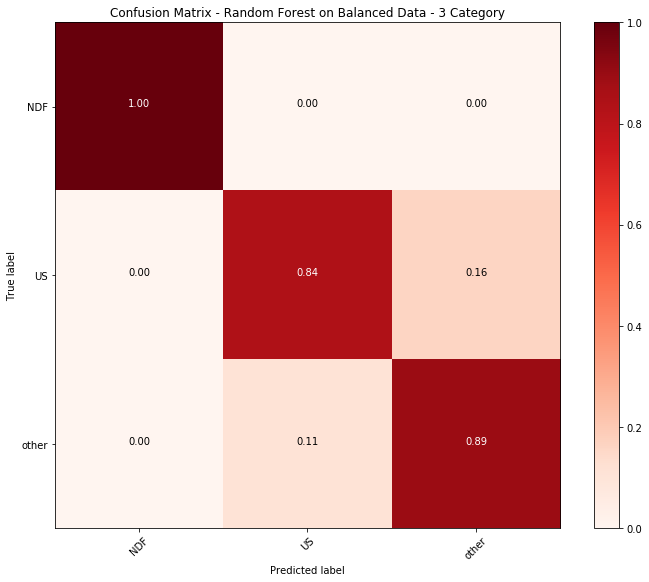

In [18]:
# The above result is scoring on the balanced test set. How well does does the balanced model work
# on the original test set?

# drop some columns from X_test that are not in the even data 
X_test_mod = X_test
for col in X_test.columns:
    if col not in X_test_even:
        X_test_mod = X_test_mod.drop(col, axis=1)
        
y_pred_full_rf = rf_even.predict(X_test_mod)

print('Score:\n', rf_even.score(X_test_mod, y_test))
print('Classification report:\n', classification_report(y_test, y_pred_full_rf))
_ = cm_plot(confusion_matrix(y_test, y_pred_full_rf), classes=sorted(y_test.unique()), 
            title='Confusion Matrix - Random Forest on Balanced Data - 3 Category', normalize=True)
plt.show()

# From the score and classification report, we can see that when the model fitted with the
# bootstrapped data is applied to the original data, it produses a result very similar to the 
# model fitted with the original data. 

# confusion matrix shows reasonibly high accuracy for US and Other

# sizable improvement in accuracy for 'other' countries using this model fitted with the balanced data

# orignal classification report. Notice the boost in recall and precision
# rf:
#              precision    recall  f1-score   support

#         NDF       1.00      1.00      1.00     12547
#          US       0.72      0.83      0.77      6256
#       other       0.33      0.20      0.25      2543

# avg / total       0.84      0.86      0.84     21346


In [22]:
# Does Extra Tree Classifer work better with the bootstrapped data? 
etc_even = ExtraTreesClassifier(n_estimators=400, n_jobs = 3)
etc_even.fit(X_train_even, y_train_even)

y_pred_even_etc = etc_even.predict(X_test_even)

print('Score:\n', etc_even.score(X_test_even, y_test_even))
print('Classification report:\n', classification_report(y_test_even, y_pred_even_etc))



Score:
 0.915477879185
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12382
         US       0.89      0.86      0.87     12533
      other       0.86      0.89      0.88     12448

avg / total       0.92      0.92      0.92     37363



Score:
 0.941206783472
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.95      0.85      0.89      6256
      other       0.70      0.89      0.78      2543

avg / total       0.95      0.94      0.94     21346



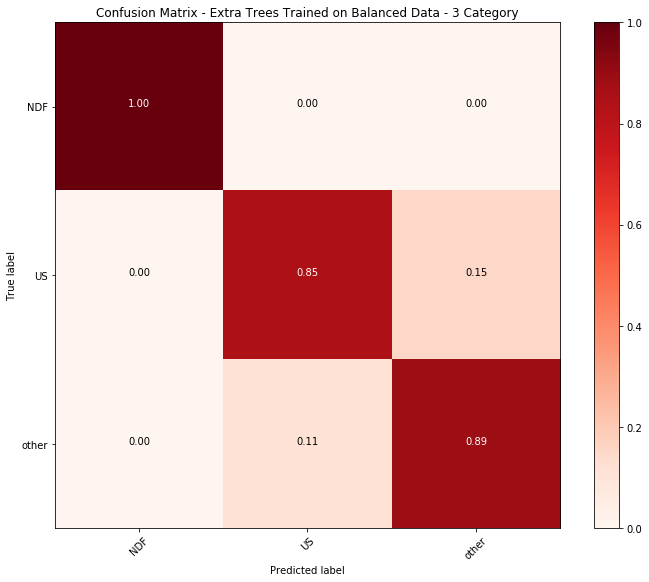

In [40]:
y_pred_full_etc = etc_even.predict(X_test_mod)

print('Score:\n', etc_even.score(X_test_mod, y_test))
print('Classification report:\n', classification_report(y_test, y_pred_full_etc))

_ = cm_plot(confusion_matrix(y_test, y_pred_full_etc), classes=sorted(y_test.unique()), 
            title='Confusion Matrix - Extra Trees Trained on Balanced Data - 3 Category', normalize=True)
plt.show()

# Similar result to RF. Slight improvement.


In [39]:
# feature importance indicates that days_to_book is the most relavent column (expected)
# then age, then gender. 
feat_import = dict(zip(X_onehot_even.columns, etc_even.feature_importances_))
feat_import = sorted(feat_import.items(), key=lambda x: x[1], reverse=True)

for item in feat_import:
    print('{0}: {1}'.format(item[0], item[1]))

age: 0.1079239964061044
days_to_book: 0.7094837714383506
gender_FEMALE: 0.006404436099351556
gender_MALE: 0.00585927296662729
gender_OTHER: 0.0004934793771814235
gender_UNKNOWN: 0.008794162405919822
signup_method_basic: 0.006397242716123419
signup_method_facebook: 0.006019975037539605
signup_method_google: 6.504991576847019e-05
signup_flow_0: 0.004359944635782253
signup_flow_1: 0.0007816781035317684
signup_flow_2: 0.0029448521120665734
signup_flow_3: 0.003862047796307014
signup_flow_5: 1.9546250903835945e-05
signup_flow_6: 0.00014597541241504256
signup_flow_8: 0.00040477621974046413
signup_flow_10: 2.545715394053061e-06
signup_flow_12: 0.0005291533973404184
signup_flow_15: 7.147781752529609e-06
signup_flow_16: 2.1124708200142267e-05
signup_flow_20: 8.926010252025204e-06
signup_flow_21: 0.00025014357716800873
signup_flow_23: 0.00030338890980141707
signup_flow_24: 0.0006875703372464208
signup_flow_25: 0.001045629826816845
language_ca: 3.0765165434802517e-06
language_cs: 4.137409054564792

Score:
 0.716296871236
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12382
         US       0.58      0.59      0.58     12533
      other       0.58      0.57      0.57     12448

avg / total       0.72      0.72      0.72     37363

Score:
 0.827696055467
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.77      0.59      0.67      6256
      other       0.36      0.57      0.44      2543

avg / total       0.86      0.83      0.84     21346



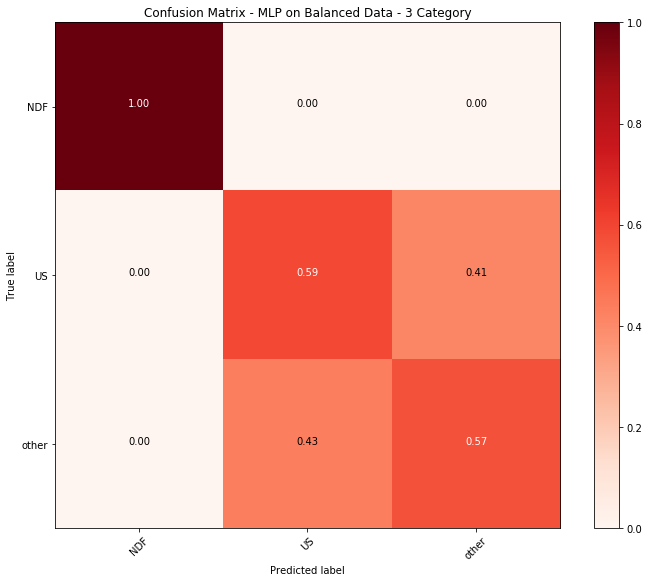

In [34]:
# and MLP
# Does Extra Tree Classifer work better with the bootstrapped data? 
mlp_even = MLPClassifier()
mlp_even.fit(X_train_even, y_train_even)

y_pred_even_mlp = mlp_even.predict(X_test_even)

print('Score:\n', mlp_even.score(X_test_even, y_test_even))
print('Classification report:\n', classification_report(y_test_even, y_pred_even_mlp))


y_pred_full_mlp = mlp_even.predict(X_test_mod)
print('Score:\n', mlp_even.score(X_test_mod, y_test))
print('Classification report:\n', classification_report(y_test, y_pred_full_mlp))

_ = cm_plot(confusion_matrix(y_test, y_pred_full_mlp), classes=sorted(y_test.unique()), 
            title='Confusion Matrix - MLP on Balanced Data - 3 Category', normalize=True)
plt.show()

# not a great result with MLP, just like when appliyng MLP to balanced 12-category classification

Score:
 0.873090311125


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report:
              precision    recall  f1-score   support

         AU       0.00      0.00      0.00       539
         CA       0.00      0.00      0.00      1428
         DE       0.00      0.00      0.00      1061
         ES       0.00      0.00      0.00      2249
         FR       0.00      0.00      0.00      5023
         GB       0.00      0.00      0.00      2324
         IT       0.00      0.00      0.00      2835
        NDF       1.00      1.00      1.00    124543
         NL       0.00      0.00      0.00       762
         PT       0.00      0.00      0.00       217
         US       0.95      0.85      0.89     62376
      other       0.27      0.88      0.41     10094

avg / total       0.87      0.87      0.86    213451



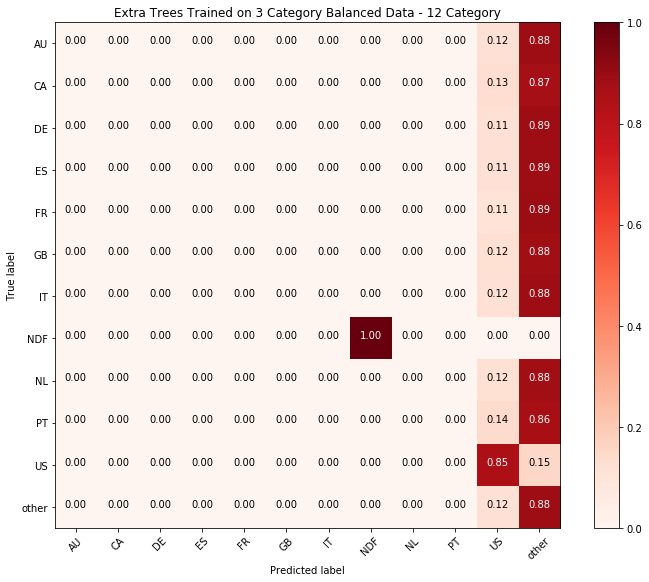

In [58]:
# ETC trained with the balanced data gave the most accurate results in the 3-category classification
# what if I try to score the country_destination (12 category) using the 3 category trained model?

# create X and y
y12 = df.country_destination
X12 = df.drop(['id', 'country_group', 'country_destination', 'date_account_created', 'timestamp_first_active', 
        'date_first_booking'], axis=1)

# specify type for signup flow
X12['signup_flow'] = X12['signup_flow'].astype('category')
# One hot encoding of categorical variables 
# using Pandas get_dummies method
X12_onehot = pd.get_dummies(X12) 
X12_onehot.age = X12_onehot.age.fillna(0)
X12_onehot.days_to_book = X12_onehot.days_to_book.fillna(100000)

for col in X12_onehot.columns:
    if col not in X_test_even:
        X12_onehot = X12_onehot.drop(col, axis=1)

y_pred_etc_12 = etc_even.predict(X12_onehot)

print('Score:\n', etc_even.score(X12_onehot, y12))
print('Classification report:\n', classification_report(y12, y_pred_etc_12))

_ = cm_plot(confusion_matrix(y12, y_pred_etc_12), classes=sorted(y12.unique()), 
            title='Extra Trees Trained on 3 Category Balanced Data - 12 Category', normalize=True)
plt.show()

# interesting result. Even on the original data, when attempting to predict 12 category classification
# using the 3 category trained model, I get very high accuracy for the 3 categories modeled. 
# zero for all others, obviously. 

Score:
 0.871516179357


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report:
              precision    recall  f1-score   support

         AU       0.00      0.00      0.00       539
         CA       0.00      0.00      0.00      1428
         DE       0.00      0.00      0.00      1061
         ES       0.00      0.00      0.00      2249
         FR       0.00      0.00      0.00      5023
         GB       0.00      0.00      0.00      2324
         IT       0.00      0.00      0.00      2835
        NDF       1.00      1.00      1.00    124543
         NL       0.00      0.00      0.00       762
         PT       0.00      0.00      0.00       217
         US       0.95      0.84      0.89     62376
      other       0.27      0.89      0.41     10094

avg / total       0.87      0.87      0.86    213451



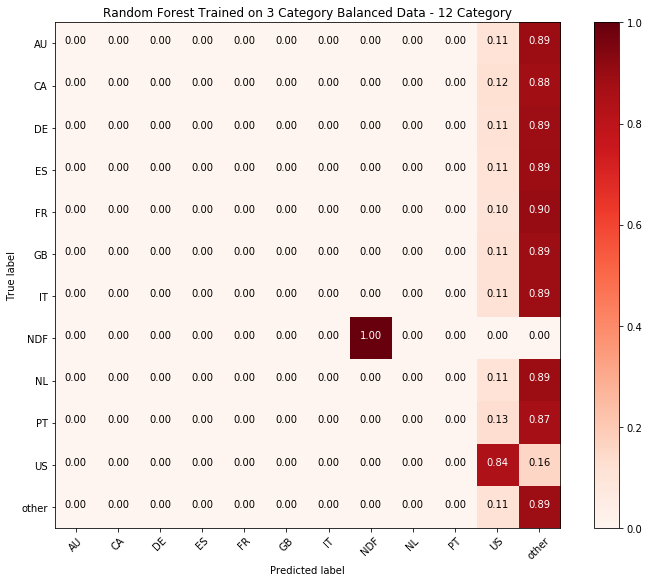

In [59]:
# Does our RF trained 3-category model give a similar result?

y_pred_rf_12 = rf_even.predict(X12_onehot)

print('Score:\n', rf_even.score(X12_onehot, y12))
print('Classification report:\n', classification_report(y12, y_pred_rf_12))

_ = cm_plot(confusion_matrix(y12, y_pred_rf_12), classes=sorted(y12.unique()), 
            title='Random Forest Trained on 3 Category Balanced Data - 12 Category', normalize=True)
plt.show()


In [19]:
# if I eliminate the NDFs, can sklearn differentiate between US and other?
df_nondf = df.loc[df['country_group'] != 'NDF']
# Separate into target and features datasets

# target variable is the destination country
X_train_nondf, X_test_nondf, y_train_nondf, y_test_nondf = create_test_train(df_nondf)
# lets try a classifier I've never used before
ada_two = AdaBoostClassifier(n_estimators=500)
ada_two.fit(X_train_nondf, y_train_nondf)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None)

Score:
 0.701945787875
Classification report:
              precision    recall  f1-score   support

         US       0.70      1.00      0.82      6240
      other       0.51      0.01      0.01      2651

avg / total       0.65      0.70      0.58      8891

Confusion matrix:
 [[6222   18]
 [2632   19]]


Text(0.5,35.1906,'Predicted label')

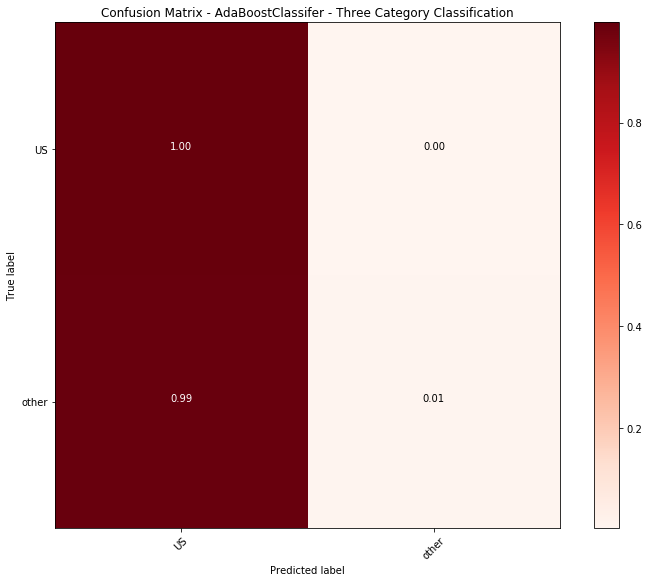

In [20]:
y_nondf_pred = ada_two.predict(X_test_nondf)

print('Score:\n', ada_two.score(X_test_nondf, y_test_nondf))
print('Classification report:\n', classification_report(y_test_nondf, y_nondf_pred))
print('Confusion matrix:\n', confusion_matrix(y_test_nondf, y_nondf_pred))

cm_plot(confusion_matrix(y_test_nondf, y_nondf_pred), classes=sorted(y_test_nondf.unique()), 
        title='Confusion Matrix - AdaBoostClassifer - Three Category Classification', normalize=True)

# not a good result. Basically, the model just guessed US for every observation

Score:
 0.64143515915
Classification report:
              precision    recall  f1-score   support

         US       0.71      0.83      0.77      6240
      other       0.33      0.19      0.24      2651

avg / total       0.59      0.64      0.61      8891

Confusion matrix:
 [[5195 1045]
 [2143  508]]


Text(0.5,35.1906,'Predicted label')

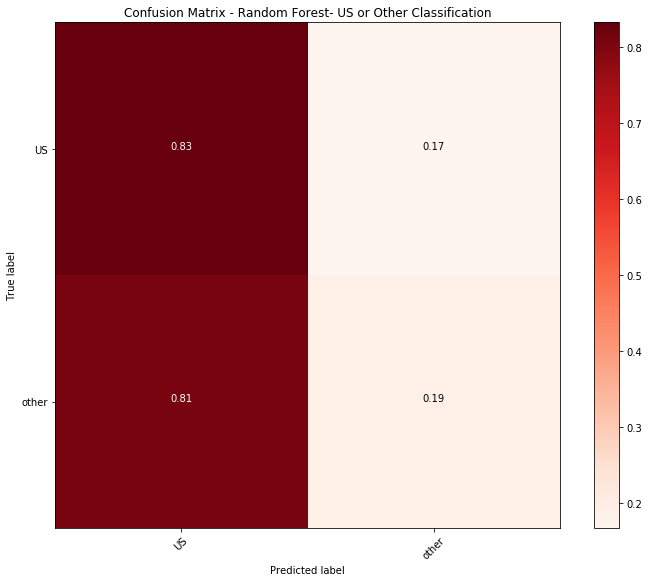

In [60]:
# how about Random Forest on the 2-category US or Other data
rf_two = RandomForestClassifier(n_estimators=500, n_jobs=3, max_features='auto')
rf_two.fit(X_train_nondf, y_train_nondf)

y_nondf_pred_rf = rf_two.predict(X_test_nondf)

print('Score:\n', rf_two.score(X_test_nondf, y_test_nondf))
print('Classification report:\n', classification_report(y_test_nondf, y_nondf_pred_rf))
print('Confusion matrix:\n', confusion_matrix(y_test_nondf, y_nondf_pred_rf))

cm_plot(confusion_matrix(y_test_nondf, y_nondf_pred_rf), classes=sorted(y_test_nondf.unique()), 
        title='Confusion Matrix - Random Forest - US or Other Classification', normalize=True)

# RF also had a hard time disginquising between US and non-US destinations

In [71]:
# If we take our balaned data and apply 2-category classification, do we get an improved result?

df_nondf_even = df_even.loc[df_even['country_group'] != 'NDF']
X_train_nondf_even, X_test_nondf_even, y_train_nondf_even, y_test_nondf_even = create_test_train(df_nondf)

rf_nondf_even = RandomForestClassifier(n_estimators=500, n_jobs=3, max_features='auto')
rf_nondf_even.fit(X_train_nondf_even, y_train_nondf_even)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Score:
 0.641660105725
Classification report:
              precision    recall  f1-score   support

         US       0.71      0.84      0.77      6240
      other       0.32      0.19      0.24      2651

avg / total       0.59      0.64      0.61      8891

Confusion matrix:
 [[5213 1027]
 [2159  492]]


Text(0.5,35.1906,'Predicted label')

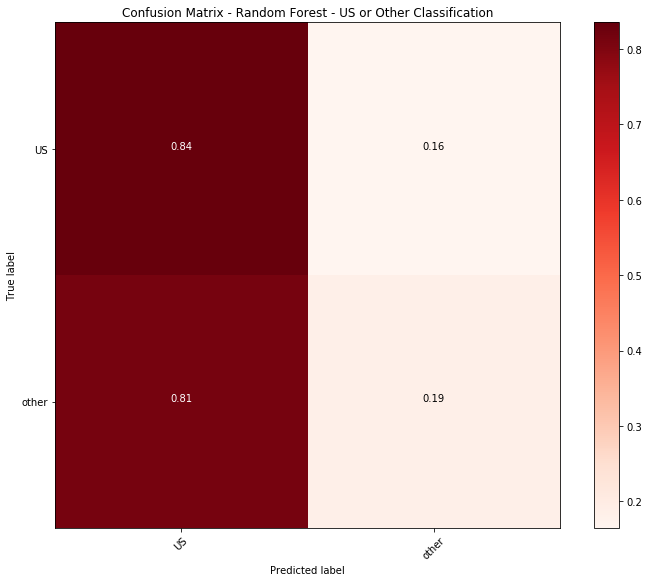

In [72]:
y_nondf_even_pred_rf = rf_nondf_even.predict(X_test_nondf_even)

print('Score:\n', rf_nondf_even.score(X_test_nondf_even, y_test_nondf_even))
print('Classification report:\n', classification_report(y_test_nondf_even, y_nondf_even_pred_rf))
print('Confusion matrix:\n', confusion_matrix(y_test_nondf_even, y_nondf_even_pred_rf))

cm_plot(confusion_matrix(y_test_nondf_even, y_nondf_even_pred_rf), classes=sorted(y_test_nondf.unique()), 
        title='Confusion Matrix - Random Forest - US or Other Classification', normalize=True)

# strange that this doesn't work, when the 3-category classificaton with the balanced data
# is very accurate with RF

In [27]:
# Does AdaBoost work on 3 cat?

ada_three = AdaBoostClassifier(n_estimators=500)
ada_three.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None)

Score:
 0.794856179144
Classification report:
              precision    recall  f1-score   support

        NDF       1.00      1.00      1.00     12547
         US       0.72      0.48      0.58      6256
      other       0.30      0.55      0.39      2543

avg / total       0.84      0.79      0.80     21346

Confusion matrix:
 [[12547     0     0]
 [    0  3033  3223]
 [    0  1156  1387]]


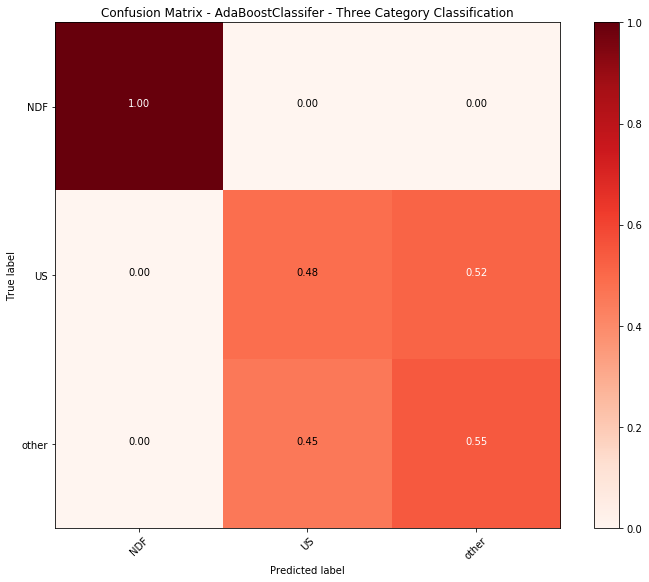

In [28]:
y_pred_ada = ada_three.predict(X_test)
print('Score:\n', ada_three.score(X_test, y_test))
print('Classification report:\n', classification_report(y_test, y_pred_ada))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_ada))

_ = cm_plot(confusion_matrix(y_test, y_pred_ada), classes=sorted(y_test.unique()), 
        title='Confusion Matrix - AdaBoostClassifer - Three Category Classification', normalize=True)

plt.show()
# still has trouble distinguisng US from other